In [ ]:
#hide
import sys
sys.path.append("..")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#default_exp core

# Core

> Data types and more

In [ ]:
#export
from mlchaos.imports import *
from timeseries.all import *
from fastai.basics import *
from fastai.vision.data import get_grid
import numpy as np
import matplotlib.cm as cm

In [ ]:
#export
class StandardizeGlobal(ItemTransform):
    def setups(self, items):
        self.mean, self.std = get_mean_std(torch.stack(list(items)), scale_subtype='all_sam')
        print(self.mean, self.std)
    def encodes(self, x):
        return (x-self.mean)/self.std
    def decodes(self, x):
        f = to_cpu if x.device.type=='cpu' else noop
        return (x*f(self.std) + f(self.mean))

In [ ]:
#export
class StandardizeItem(ItemTransform):
    "Standardize item per sample per channel"
    def encodes(self, x):
        self.mean = x.mean(axis=1).unsqueeze(1).repeat(1, x.shape[1])
        self.std = x.std(axis=1).unsqueeze(1).repeat(1, x.shape[1])
        return (x - self.mean)/ self.std
    def decodes(self, x):
        f = to_cpu if x.device.type=='cpu' else noop
        return (x*f(self.std) + f(self.mean))

In [ ]:
#export
class StandardizeNoDecode(Standardize):
    def decodes(self, x:TensorTS):
        return x

## Override things from TensorTS

TODO: Pull request to the timeseries library

In [ ]:
#export
@typedispatch
def plot_top_losses(x:TensorTS, y:TensorCategory, samples, outs, raws, losses, nrows=None, ncols=None, figsize=None, **kwargs):
    axs = get_grid(len(samples), nrows=nrows,
                   ncols=ncols, add_vert=1,
                   figsize=figsize, title='Prediction/Actual/Loss/Probability')
    for ax,s,o,r,l in zip(axs, samples, outs, raws, losses):
        s[0].show(ctx=ax, **kwargs)
        ax.set_title(f'{o[0]}/{s[1]} / {l.item():.2f} / {r.max().item():.2f}')

## TensorMotion

Class that redefines show method to show a poincare map for a motion

In [ ]:
#export
class TensorMotion(TensorTS):
    def show(self, ctx=None, title=None, label=None, chs=None,
             leg=True, ylim=None, return_fig=False, mode=None, 
             am=None, cmap='inferno', fig=None, **kwargs):
        r"""
        Show method with different modes. Important arguments:
            * mode: They way the motion will show itself:
                - None: Poincare map
                - ts: Time series plot with all the channels (x,y) in the same
                axis
                - stacked: x and y will be shown in different canvas
            * am: attribution map. Colour each point of the motion based on the 
            attribution marked by this map. Valid only for Poincare maps (mode = None).
        """
        if mode=='ts':
            return TensorTS.show(self, ctx, title, chs, leg, **kwargs)
            if return_fig: print('Figures cannot be returned in mode ts')
        elif mode=='stacked':
            ret = self.show_stacked(ctx, title, label, chs, leg, **kwargs)
            if return_fig: return ret
        else:
            ret = self.show_poincmap(ctx, title, label, leg, ylim, return_fig, 
                                     am=am, fig=fig, **kwargs)
            if return_fig: return ret

    def show_poincmap(self, ctx=None, title=None, label=None, leg=True,
                      ylim=None, return_fig=False, am=None, cmap='inferno', 
                      fig=None, **kwargs):
        "Display poincare map for a motion"
        if ctx is None: fig, ctx = plt.subplots()
        if am is None:
            ctx.scatter(self[0][1:], self[1][1:])
            # The initial conditions (x0, y0) are plotted in a different colour
            ctx.scatter(self[0][0], self[1][0])
        else:
            # the colours of the points will be given by the attribution map
            assert am.ndim <= 2 and (am.shape[-1] == self.shape[-1]), \
            f'Wrong dimensions in attribution_map. {am.shape}, {self.shape}'
            am = (am - am.min())/(am.max() - am.min())
            if am.ndim == 2:
                am = am[0]
            ctx.scatter(self[0], self[1], c=am, cmap=cmap)
            if leg and fig is not None:
                #display the colorbar
                scalarmappaple = cm.ScalarMappable(cmap=cmap)
                scalarmappaple.set_array(am)
                cax = fig.add_axes([ctx.get_position().x1+0.01,
                                    ctx.get_position().y0,
                                    0.02,
                                    ctx.get_position().height])
                plt.colorbar(scalarmappaple, cax=cax)
        ctx.set(xlim=[0, 360])
        if ylim: ctx.set(ylim=ylim)
        if title: ctx.set_title(title)
        if return_fig: return fig

    def show_stacked(self, ctx=None, title=None, label=None, chs=None, leg=True, 
                     color=None, **kwargs):
        "Display timeseries plots for a motion"
        t = range(self.shape[1])
        if ctx is None:
            fig , ctx = plt.subplots(nrows=2, ncols=1)
            ctx[0].plot(t, self[0], label='x', color='C0')
            ctx[0].scatter(t, self[0], color='C0', marker='.')
            ctx[1].plot(t, self[1], label='y', color='C1')
            ctx[1].scatter(t, self[1], color='C1', marker='.')
            if leg:
                ctx[0].legend(loc='upper right', ncol=2, framealpha=0.5)
                ctx[1].legend(loc='upper right', ncol=2, framealpha=0.5)
                if title: ax0.set_title(title)
            return fig
        else:
            # Call from show_batch, only plot one channel. The title is plotted in the show batch
            ch = chs[0]
            ctx.plot(t, self[ch], label=label, color=color)
            if leg: ctx.legend(loc='upper right', ncol=2, framealpha=0.5)
            if title: ctx.set_title(title)

In [ ]:
_x = np.load('../example_data/motion.npy')
x = TensorMotion(_x)
x.shape, x.device

(torch.Size([2, 200]), device(type='cpu'))

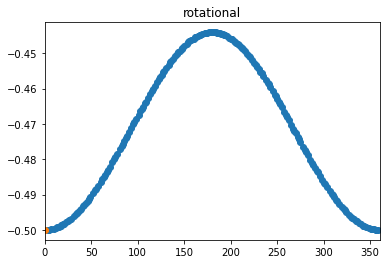

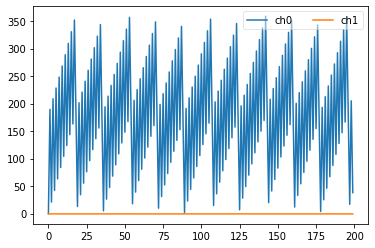

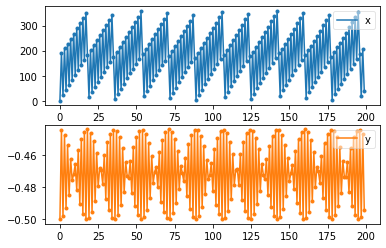

In [ ]:
x.show(title='rotational')
x.show(mode='ts')
x.show(mode='stacked')

Test attribution maps. Here they will be created randomly, normally they will 
be the result of calling the function `get_attribution_map` from `tsai`

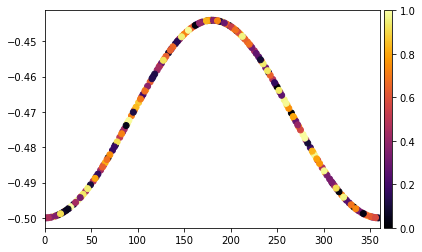

In [ ]:
am = torch.rand(x.shape)
x.show(am = am)

In [ ]:
#export
class ToTensorMotion(ItemTransform):
    # "x : 2D numpy array"
    def encodes(self, x): return TensorMotion(x)
    #def decodes(self, x): return x.numpy()

In [ ]:
#export
def MotionBlock():
    "`TransformBlock` for orbit motions. Transform np array to TensorMotion type"
    return TransformBlock(type_tfms=[ToTensorTS(), ToTensorMotion()])

In [ ]:
#export
@typedispatch
def show_results(x:TensorMotion, y, samples, outs, ctxs=None, max_n=9, nrows=None, 
                 ncols=None, mode=None, amaps=None, figsize=(15,6), cmap='inferno',
                 **kwargs):
    r"""
        Show results for TensorMotion objects
    """
    outs = [detuplify(o) for o in outs]
    if mode == 'stacked':
        n = min(len(samples), max_n)
        ncols = int(np.ceil(n/nrows))
        nchannels = 2
        if ctxs is None: fig, ctxs = plt.subplots(nchannels*nrows, ncols, figsize=figsize)
        for b, o, i in zip(samples, outs, range(max_n)):
            b[0].show(ctx=ctxs[0 + nchannels*int(i/ncols)][i%ncols], title=f'{o} / {b[1]}', label='x', chs=[0], color='C0')
            b[0].show(ctx=ctxs[1 + nchannels*int(i/ncols)][i%ncols], label='y', chs=[1], color='C1')
        prettify_plot_TensorTSMotion(ctxs, n, nchannels, nrows, ncols)
        fig.tight_layout()
    elif mode == 'ts':
        raise Exception('mode == ts not supported yet')
    else:
        # Default mode - Poincare map
        if ctxs is None: fig, ctxs = get_grid(min(len(samples), max_n), nrows=nrows, 
                                              ncols=ncols, add_vert=1, figsize=figsize, 
                                              return_fig=True)
        else:
            raise Exception('Plotting amaps with a graphic context is not allowed')
        if amaps is None:
            ctxs = [b[0].show(ctx=c, title=f'{o} / {b[1]}', figsize=figsize, 
                              cmap=cmap,**kwargs) 
                    for b,o,c,_ in zip(samples,outs,ctxs,range(max_n))]
        else:
            # Show activation maps
            assert is_listy(amaps) and len(amaps) == len(samples), \
            f'amaps must be a list with length {len(samples)}'
            # Add the color bar, need a fig object
            scalarmappaple = cm.ScalarMappable(cmap=cmap)
            # TODO: This is set with the values of just one plot
            scalarmappaple.set_array(torch.stack(amaps))
            bar_x = max([ctx.get_position().x1 for ctx in ctxs])
            #bar_y = min([ctx.get_position().y0 for ctx in ctxs])
            bar_y = (fig.get_size_inches()[1]/2 - ctxs[0].get_position().height)/\
                    (fig.get_size_inches()[1])
            cax = fig.add_axes([bar_x+0.01,bar_y, 0.02, ctxs[0].get_position().height])
            plt.colorbar(scalarmappaple, cax=cax)
            ctxs = [b[0].show(ctx=c, title=f'{o} / {b[1]}', figsize=figsize, 
                              mode=mode, am=amap, cmap=cmap, **kwargs) 
                    for b,o,amap,c,_ in zip(samples,outs,amaps,ctxs,range(max_n))]
            
            
    return ctxs

In [ ]:
from mlchaos.data import *
fnames = (Path('../example_data/Poincare.plt'), Path('../example_data/index.plt'))
data = TSDataChaos.from_poincare_and_index_files(fnames, index_col=5)
data

TSDataChaos:
 Datasets names (concatenated): ['example_data']
 Filenames:                     [(Path('../example_data/Poincare.plt'), Path('../example_data/index.plt'))]
 Data shape: (3, 2, 200)
 Targets shape: (3,)
 Nb Samples: 3
 Nb Channels:           2
 Sequence Length: 200

In [ ]:
xs = [TensorMotion(o) for o in data.x]
ys = TensorCategory(data.y)
samples = [(o1, o2) for o1, o2 in zip(xs, ys)]
outs = [(o,) for o in ys]
amaps_l = torch.unbind(torch.rand(data.x.shape)) # Attribution maps are passed as a list
len(xs), len(ys), len(samples), len(outs), len(amaps_l)

(3, 3, 3, 3, 3)

[None, None, None]

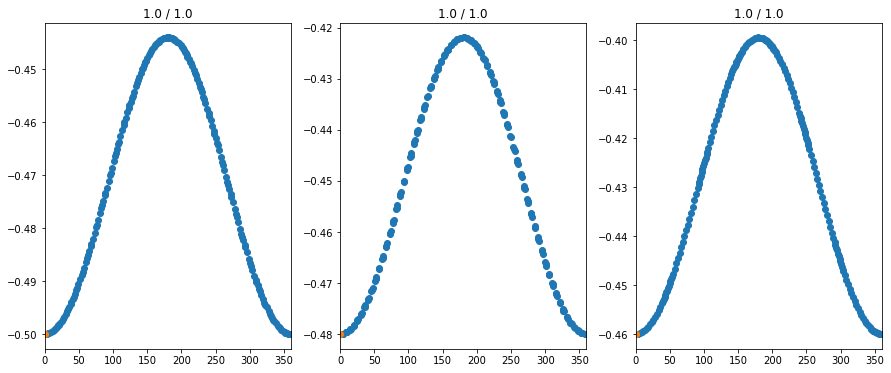

In [ ]:
show_results[TensorMotion](xs, ys, samples, outs)

[None, None, None]

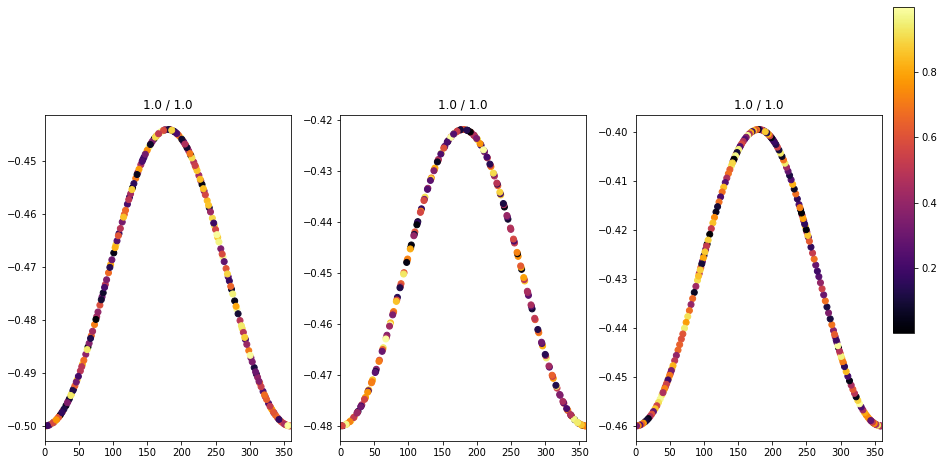

In [ ]:
show_results[TensorMotion](xs, ys, samples, outs, amaps=amaps_l)

In [ ]:
#export
@typedispatch
def plot_top_losses(x:TensorMotion, y:TensorCategory, samples, outs, raws, losses, nrows=None, ncols=None, figsize=None, **kwargs):
    axs = get_grid(len(samples), nrows=nrows,
                   ncols=ncols, add_vert=1,
                   figsize=figsize, title='Prediction/Actual/Loss/Probability')
    for ax,s,o,r,l in zip(axs, samples, outs, raws, losses):
        s[0].show(ctx=ax, **kwargs)
        ax.set_title(f'{o[0]}/{s[1]} / {l.item():.2f} / {r.max().item():.2f}')

## TensorTSMotion (deprecated)

NOTE: TensorTSMotion is now deprecated and replaced by TensorMotion

TODO: Move show_batch and show_results to TensorTSMotion

Class that redefines show methods in order to show a stacked time series with the x and y components (deprecated??)

In [ ]:
#export
class TensorTSMotion(TensorTS):
    "This class could be deprecated soon. Please see `TensorMotion`"
    def show(self, ctx=None, title=None, label=None, chs=None, leg=True, color=None, **kwargs):
        "Display timeseries plots for a motion"
        t = range(self.shape[1])
        if ctx is None:
            _, ctx = plt.subplots(nrows=2, ncols=1)
            ctx[0].plot(t, self[0], label='x', color='C0')
            ctx[1].plot(t, self[1], label='y', color='C1')
            if leg:
                ctx[0].legend(loc='upper right', ncol=2, framealpha=0.5)
                ctx[1].legend(loc='upper right', ncol=2, framealpha=0.5)
                if title: ax0.set_title(title)
        else:
            # Call from show_batch, only plot one channel. The title is plotted in the show batch
            ch = chs[0]
            ctx.plot(t, self[ch], label=label, color=color)
            if leg: ctx.legend(loc='upper right', ncol=2, framealpha=0.5)
            if title: ctx.set_title(title)

In [ ]:
#export
class ToTensorTSMotion(ItemTransform):
    # "x : 2D numpy array"
    def encodes(self, x): return TensorTSMotion(x)
    def decodes(self, x): return x.numpy()

In [ ]:
#export
def prettify_plot_TensorTSMotion(ctxs, n, nchannels, nrows, ncols):
    "Configure how to paint axes with motion plots. ctxs is a 2xN array of axes"
    for i in range(n):
        ctxs[0 + nchannels*int(i/ncols)][i%ncols].get_xaxis().set_visible(False)
        ctxs[0 + nchannels*int(i/ncols)][i%ncols].spines['bottom'].set_visible(False)
        ctxs[1 + nchannels*int(i/ncols)][i%ncols].spines['top'].set_visible(False)

In [ ]:
#export
@typedispatch
def show_batch(x:TensorTSMotion, y, samples, ctxs=None, max_n=3, nrows=1, figsize=(15,6), **kwargs):
    "Show batch for TensorTS objects"
    n = min(len(samples), max_n)
    ncols = int(np.ceil(n/nrows))
    nchannels = 2
    if ctxs is None: fig, ctxs = plt.subplots(nchannels*nrows, ncols, figsize=figsize)
    for b, tar, i in zip(samples.itemgot(0), samples.itemgot(1), range(n)):
        b.show(ctx=ctxs[0 + nchannels*int(i/ncols)][i%ncols], title = tar, label='x', chs=[0], color='C0')
        b.show(ctx=ctxs[1 + nchannels*int(i/ncols)][i%ncols], label='y', chs=[1], color='C1')
    prettify_plot_TensorTSMotion(ctxs, n, nchannels, nrows, ncols)
    fig.tight_layout()
    return ctxs

In [ ]:
#export
@typedispatch
def show_results(x:TensorTSMotion, y, samples, outs, ctxs=None, max_n=3, nrows=1, figsize=(15,6), **kwargs):
    "Show results for TensorTSMotion objects"
    n = min(len(samples), max_n)
    ncols = int(np.ceil(n/nrows))
    nchannels = 2
    if ctxs is None: fig, ctxs = plt.subplots(nchannels*nrows, ncols, figsize=figsize)
    outs = [detuplify(o) for o in outs]
    for b, o, i in zip(samples, outs, range(max_n)):
        b[0].show(ctx=ctxs[0 + nchannels*int(i/ncols)][i%ncols], title=f'{o} / {b[1]}', label='x', chs=[0], color='C0')
        b[0].show(ctx=ctxs[1 + nchannels*int(i/ncols)][i%ncols], label='y', chs=[1], color='C1')
    prettify_plot_TensorTSMotion(ctxs, n, nchannels, nrows, ncols)
    fig.tight_layout()
    return ctxs

In [ ]:
#export
@typedispatch
def plot_top_losses(x:TensorTSMotion, y:TensorCategory, samples, outs, raws, losses, nrows=1, figsize=None, **kwargs):
    #axs = get_grid(len(samples), nrows=nrows, ncols=ncols, add_vert=1, figsize=figsize, title='Prediction/Actual/Loss/Probability')
    n = len(samples)
    ncols = int(np.ceil(n/nrows))
    nchannels = 2
    fig, ctxs = plt.subplots(nchannels*nrows, ncols, figsize=figsize)
    for s,o,r,l,i in zip(samples, outs, raws, losses, range(len(samples))):
        s[0].show(ctx=ctxs[0 + nchannels*int(i/ncols)][i%ncols], label='x', chs=[0], color='C0', **kwargs)
        s[0].show(ctx=ctxs[1 + nchannels*int(i/ncols)][i%ncols], label='y', chs=[1], color='C1', **kwargs)
        ctxs[0 + nchannels*int(i/ncols)][i%ncols].set_title(f'{o[0]}/{s[1]} / {l.item():.2f} / {r.max().item():.2f}')
    prettify_plot_TensorTSMotion(ctxs, n, nchannels, nrows, ncols)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.suptitle('Prediction/Actual/Loss/Probability')

### Export

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()
beep(1)

Converted cam.ipynb.
Converted core.ipynb.
Converted data.ipynb.
Converted experiments.ipynb.
Converted index.ipynb.
Converted utils.ipynb.
